In [1]:
Z_DIM = 2

### 1. Load Colored MNIST dataset

In [161]:
import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.utils as vutils

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q torchsummary
from torchsummary import summary

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete
pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

from matplotlib.gridspec import GridSpec

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        # self.T = transforms.Compose([
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            # 'img': self.T(ims),
            'img': ims,
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [165]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))

60000 10000 4926


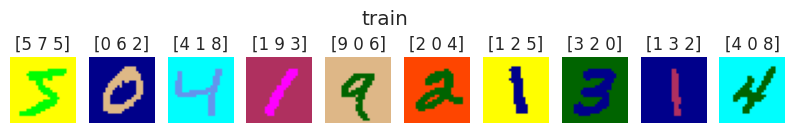

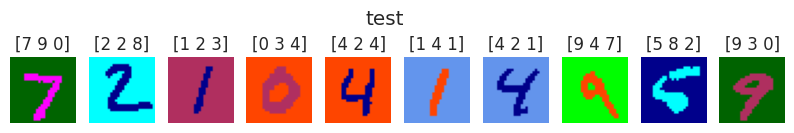

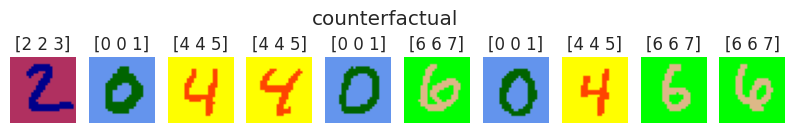

In [169]:
def normalize(img):
    # a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img #* a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [170]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

### 2. CVAEGAN

In [171]:
def weights_init(model):
    ''' Инициализация весов генератора и дискриминатора '''

    classname = model.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

def get_one_hot(labels):
    new_ys = []
    for i, label_length in enumerate(LABEL_SIZES):
        new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
        new_ys.append(new_y)
    new_ys = torch.cat(new_ys, -1)
    return new_ys.to(torch.float32)

In [172]:
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Decoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Linear(z_dim+label_dim, 64*7*7),
            Reshape((-1, 64, 7, 7)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        data = torch.cat([z, get_one_hot(labels)], dim=1)
        prob_output = self.layers(data)
        return prob_output

class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3136, z_dim)
        self.fc_output_scale = nn.Linear(3136, z_dim)

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        hidden = self.layers(data)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

    # def forward(self, x, labels):
    #     labels = get_one_hot(labels)
    #     # labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
    #     hidden = self.layers(x)
    #     data = torch.cat([hidden, labels], dim=1)  # (BS, 64+30?, 28, 28)
    #     z_loc = self.fc_output_loc(data)
    #     z_scale = torch.exp(self.fc_output_scale(data))
    #     return z_loc, z_scale

class Discriminator(nn.Module):
    def __init__(self, label_dim=30, p=0.3):
        super(Discriminator, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 128, 5, 2, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p),
            nn.Linear(2304, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        return self.layers(data)


In [173]:
# dec = Decoder().to('cuda') #940,483
# summary(dec, ([(Z_DIM,), (3,)]))
# enc = Encoder().to('cuda')
# summary(enc, ([(3, 28, 28), (3,)]))
# disc = Discriminator().to('cuda') # 60k?
# summary(disc, ([(3, 28, 28), (3,)]))

In [174]:
class CVAE_GAN(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim, label_dim=label_dim, p=p)
        self.discriminator_ = Discriminator(label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.device = 'cuda' if use_cuda else 'cpu'
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(z, labels)
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

            # is_real part
            prob_real = self.discriminator_(loc_img, labels).squeeze()
            prob_real = prob_real.expand([28*28*3, *prob_real.shape]).T
            ones = torch.full((x.shape[0],), 1., dtype=torch.float, device=self.device)
            ones = ones.expand([28*28*3, *ones.shape]).T
            pyro.sample("is_real", dist.Bernoulli(prob_real).to_event(1), obs=ones)

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def model_generate(self, batch_size):
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)
        with pyro.plate("data", batch_size):
            # pior for Z
            z_loc = torch.zeros(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z_scale = torch.ones(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z = dist.Normal(z_loc, z_scale).rsample()

            # random labels for generation
            rand_labels = torch.randint(low=0, high=10, size=(batch_size, 3), device=self.device)
            loc_img = self.decoder_(z, rand_labels)
            prob_real = self.discriminator_(loc_img, rand_labels).squeeze()
            ones = torch.full((batch_size,), 1., dtype=torch.float, device=self.device)
            pyro.sample("obs", dist.Bernoulli(prob_real), obs=ones)

    def guide_generate(self, batch_size):
        pass

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    def reconstruct_img(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

In [175]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()
real_label = 1.
fake_label = 0.

def train_discriminator(model, optimizer, criterion, real_batch, real_labels, label_dim=30, z_dim=Z_DIM):
    model.discriminator_.zero_grad()
    model.discriminator_.train(True)
    batch_size = real_batch.size(0)

    ## Обучение по реальным объетам
    label = torch.full(  # вектор из одинаковых меток real_label
        (batch_size,), real_label, dtype=torch.float, device=device
    )

    output = model.discriminator_(real_batch, real_labels).view(-1)
    error_real = criterion(output, label)
    error_real.backward()
    mean_real = output.mean().item()


    ## Обучение по восстановленным объектам
    label = torch.full(  # вектор из одинаковых меток fake_label
        (batch_size,), fake_label, dtype=torch.float, device=device
    )
    # Восстановленные объекты
    predicted_batch = model.reconstruct_img(real_batch, real_labels, return_cpu=False)

    output = model.discriminator_(predicted_batch, real_labels).view(-1)
    error_predicted = criterion(output, label)
    error_predicted.backward()
    mean_predicted = output.mean().item()


    ## Обучение по сгенерированным объектам
    label = torch.full(  # вектор из одинаковых меток fake_label
        (batch_size,), fake_label, dtype=torch.float, device=device
    )
    # Сгенерированные объекты
    rand_labels = torch.randint(low=0, high=10, size=(real_batch.shape[0], 3), device=device)
    noise = torch.randn(real_batch.shape[0], z_dim, device=device)
    fake_batch = model.decoder(noise, rand_labels, return_cpu=False).detach()

    output = model.discriminator_(fake_batch, rand_labels).view(-1)
    error_fake = criterion(output, label)
    error_fake.backward()
    mean_fake = output.mean().item()

    # Считаем общую ошибку
    error = error_real + error_predicted + error_fake

    # Обновляем веса дискриминатора
    optimizer.step()

    return error, mean_real, mean_predicted, mean_fake


def train_vae(model, svi_vae, svi_generator, real_batch, real_labels):
    model.discriminator_.train(False)
    model.encoder_.zero_grad()
    model.decoder_.zero_grad()

    elbo1 = -svi_vae.step(real_batch, real_labels)
    elbo2 = -svi_generator.step(real_batch.shape[0])
    return elbo1 + elbo2


def callback(losses_elbo, losses_discriminator, D_real_means, D_fake_means,
             DG_fake_means, it):
    clear_output(wait=True)
    plt.figure(figsize=(20, 5), constrained_layout=False)
    plt.suptitle(f'Итерация {it}', y=1.02)
    plt.subplot(131)
    plt.plot(losses_discriminator, lw=2, label='дискр.')
    plt.title('BCELoss')
    plt.legend()
    plt.xlabel('Номер итерации')
    plt.subplot(132)
    plt.plot(losses_generator, lw=2, label='VAE')
    plt.title('ELBO')
    plt.legend()
    plt.xlabel('Номер итерации')
    plt.subplot(133)
    plt.plot(D_real_means, lw=2, label='реальные', alpha=0.7)
    plt.plot(D_fake_means, lw=2, label='сгенер.', alpha=0.7)
    plt.plot(DG_fake_means, lw=2, label='восст.', alpha=0.7)
    plt.title('Среднее значение выхода дискриминатора')
    plt.ylabel('Вероятность истинности картинки')
    plt.xlabel('Номер итерации')
    plt.legend()
    plt.tight_layout()
    plt.show()

### 3. Train

In [178]:
num_iter = 2000
n_iter_generator = 10
n_iter_discriminator = 10
callback_frequency = 25
picture_save_frequency = 100
batch_size = 128

pyro.clear_param_store()
vae = CVAE_GAN(p=0.2, use_cuda=USE_CUDA)
vae.encoder_.apply(weights_init);
vae.decoder_.apply(weights_init);
vae.discriminator_.apply(weights_init);


# Создадим фиксированный батч латентных векторов для визуализации
fixed_noise = torch.randn(batch_size, Z_DIM, device=device)
fixed_labels = torch.randint(low=0, high=10, size=(batch_size, 3), device=device)
lr = 0.0003
beta1 = 0.5
criterion = nn.BCELoss()

# Создаем объект вариационного вывода для обучения по восстановленным объектам.
# Этот вариационный вывод обучает энкодер и декодер/генератор.
optimizer_vae = pyro.optim.Adam({"lr": lr, "betas": (beta1, 0.999)})
svi_vae = SVI(vae.model, vae.guide, optimizer_vae, loss=Trace_ELBO())

# Создаем объект вариационного вывода для обучения по сгенерированным объектам
# Этот вариационный вывод обучает только декодер/генератор.
optimizer_generator = pyro.optim.Adam({"lr": lr, "betas": (beta1, 0.999)})
svi_generator = SVI(vae.model_generate, vae.guide_generate, optimizer_generator, loss=Trace_ELBO())

# Оптимизаторы
lr_disc = 0.0001
optim_discriminator = torch.optim.Adam(vae.discriminator_.parameters(), lr=lr_disc, betas=(beta1, 0.999))

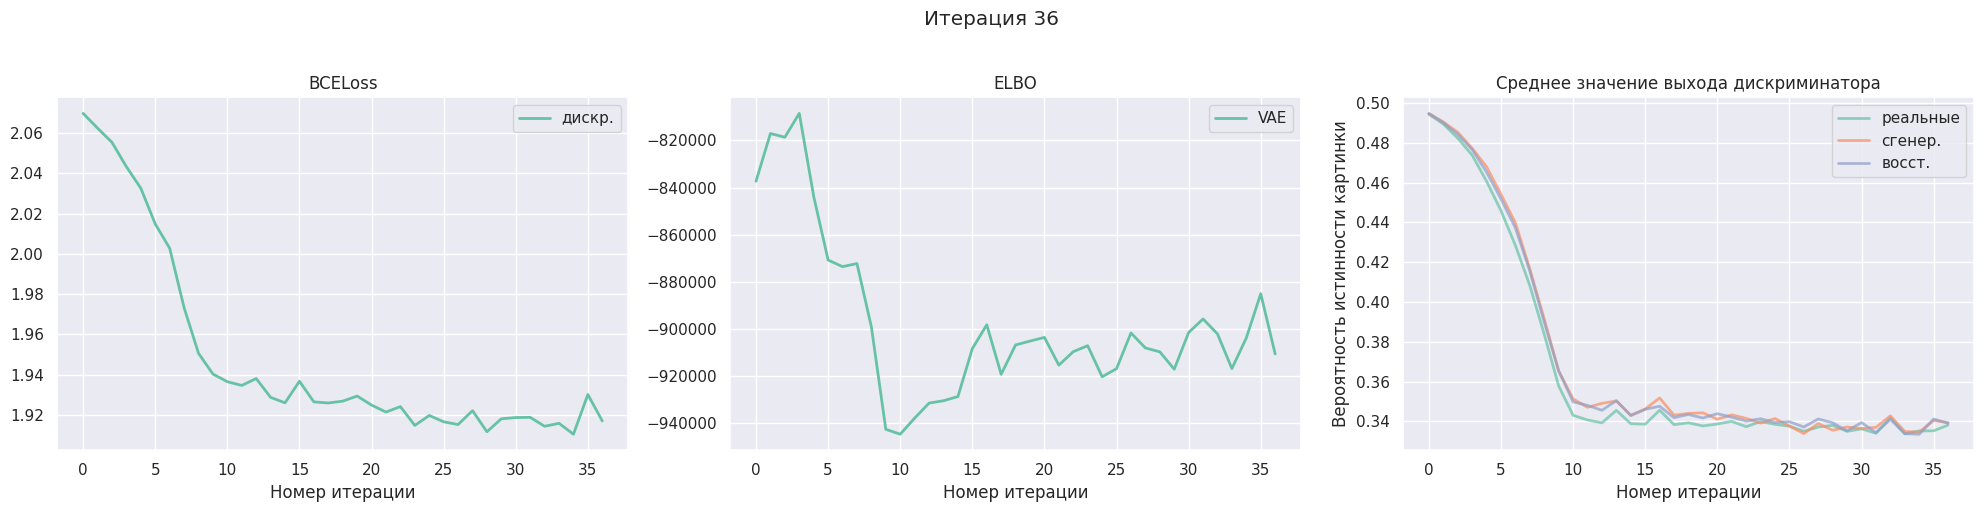

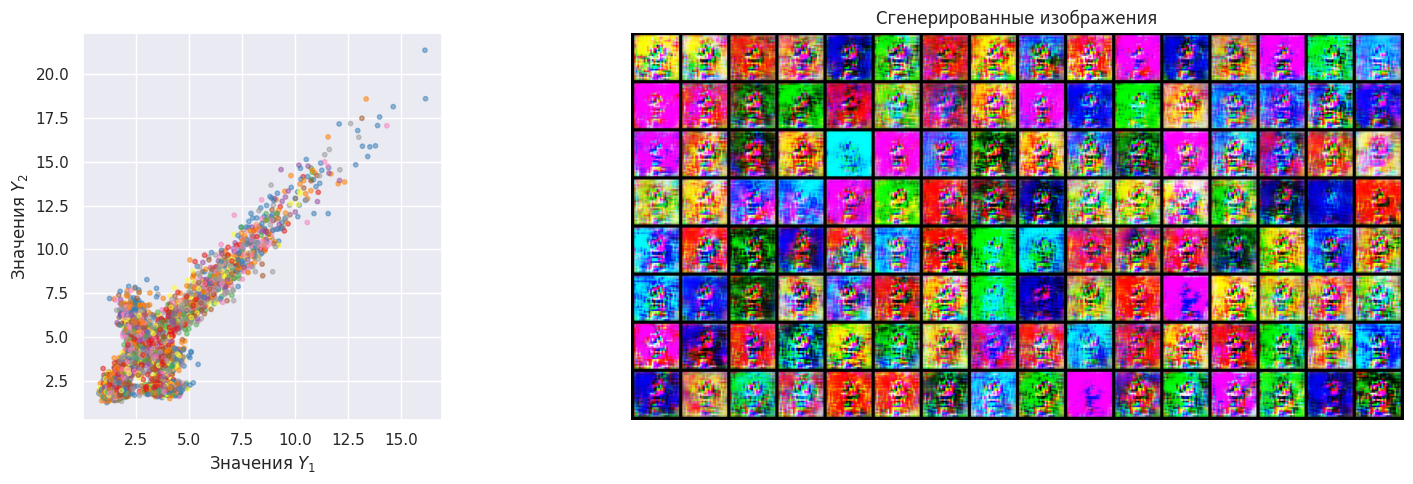

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bddb4cbb370>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 
Exception ignored in: Exception ignored in: <function _after_fork at 0x7bdea3cbdb40><function _after

KeyboardInterrupt: 

In [179]:
# Трассировка обучения
losses_generator = []
losses_discriminator = []
D_real_means, D_fake_means, DG_fake_means = [], [], []

for it in range(num_iter):
    # Обучаем дискриминатор
    for _ in range(n_iter_discriminator):
        # Батч реальных объектов
        batch = next(iter(train_loader))
        real_batch = batch['img']
        real_labels = batch['label']
        real_batch = real_batch.to(device)
        real_labels = real_labels.to(device)

        # Итерация. Батч сгенерированных создается внутри
        return_discr = train_discriminator(
            vae,
            optim_discriminator,
            criterion,
            real_batch,
            real_labels
        )

    # Обучаем энкодер и декодер/генератор
    for _ in range(n_iter_generator):
        # Батч реальных объектов
        batch = next(iter(train_loader))
        real_batch = batch['img']
        real_labels = batch['label']
        real_batch = real_batch.to(device)
        real_labels = real_labels.to(device)

        return_vae = train_vae(
            vae,
            svi_vae,
            svi_generator,
            real_batch,
            real_labels,
        )

    torch.save(vae.state_dict(), '/content/drive/MyDrive/thesis/vaegan.pt')

    # Сохраняем значения для визуализации трассировки
    losses_generator.append(return_vae)
    losses_discriminator.append(return_discr[0].item())
    D_real_means.append(return_discr[1])
    D_fake_means.append(return_discr[3])
    DG_fake_means.append(return_discr[2])

    # Визуализация
    if it % 2 == 0:
        callback(losses_generator, losses_discriminator, D_real_means,
                 D_fake_means, DG_fake_means, it)

        labels = []
        z_all = []
        for batch in test_loader:
            x = batch['img']
            l = batch['label']
            labels.append(l.detach().numpy())
            z = vae.encoder(x, l)[0].detach().numpy()
            z_all.append(z)

        labels = np.concatenate(labels)
        z_all = np.vstack(z_all)

        fig = plt.figure(figsize=(16, 5))
        gs = GridSpec(1, 4, figure=fig)
        y_graph = fig.add_subplot(gs[0, 0])
        y_graph.scatter(z_all[:, 0], z_all[:, 1], c=labels[:, 0], cmap='Set1', alpha=0.5, s=10)
        y_graph.set_xlabel('Значения $Y_1$')
        y_graph.set_ylabel('Значения $Y_2$')

    # Сохраняем текущие версии сгенерированных изображений
    # if (it % picture_save_frequency == 0) or (it == num_iter-1):
        # Получаем текущие изображения по фиксированному шуму
        with torch.no_grad():
            fake = vae.decoder(fixed_noise, fixed_labels).detach().cpu()
        # Преобразуем их в одну картинку сеткой 16 на 16
        gen_img = vutils.make_grid(fake, nrow=16, padding=2, normalize=True)

        pic_graph = fig.add_subplot(gs[0, 1:])
        pic_graph.axis("off")
        pic_graph.set_title("Сгенерированные изображения")
        pic_graph.imshow(normalize(np.transpose(gen_img, (1,2,0))))
        plt.tight_layout()
        plt.show()

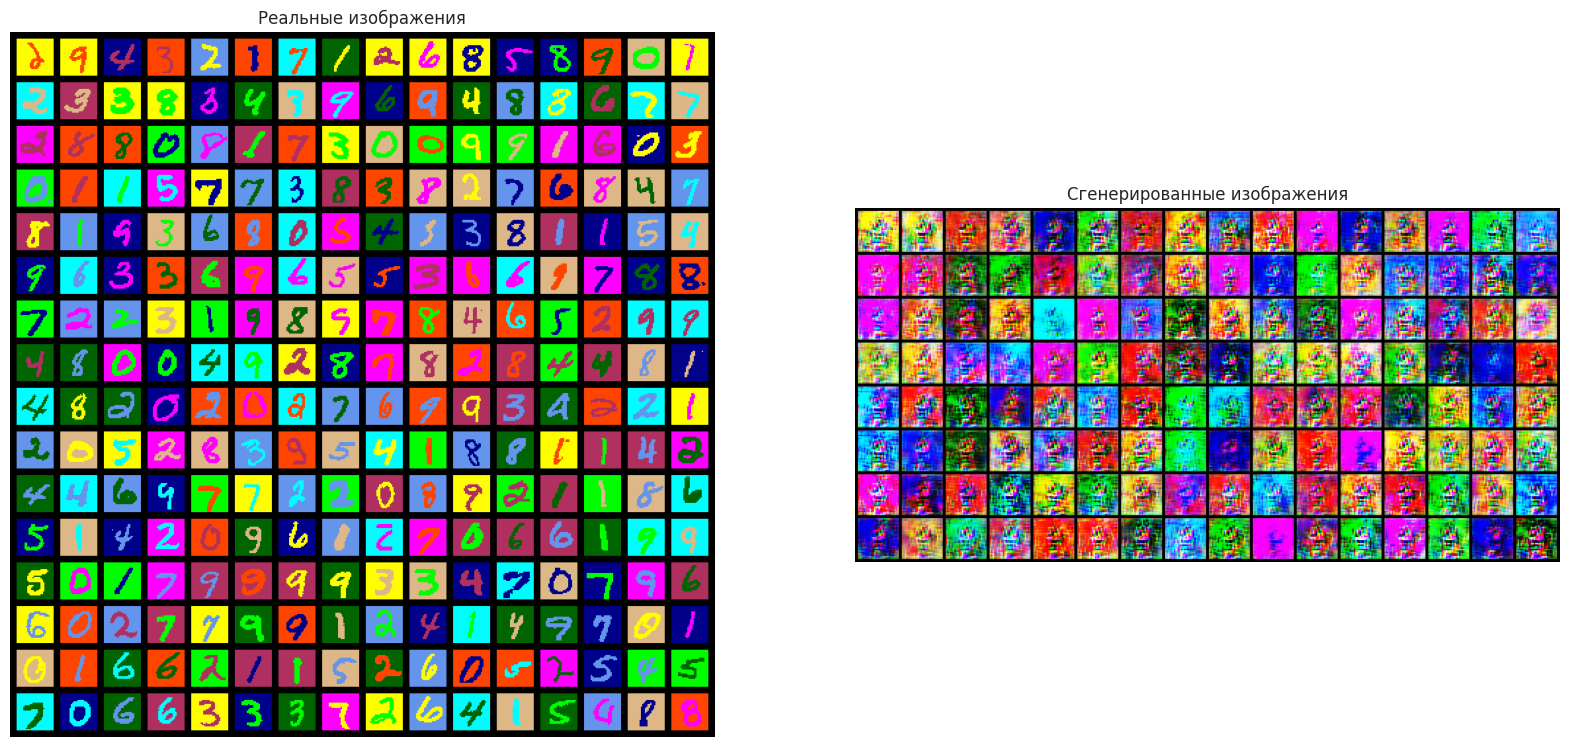

In [180]:
# Извлечем батч реальных изображений
real_batch = next(iter(train_loader))

# Рисуем реальные изображения
plt.figure(figsize=(20, 11))
plt.subplot(121)
plt.axis("off")
plt.title("Реальные изображения")
plt.imshow(np.transpose(vutils.make_grid(
    real_batch['img'].to(device)[:256], nrow=16, padding=5, normalize=True
).cpu(), (1,2,0)))

# Рисуем сгенерированные изображения
plt.subplot(122)
plt.axis("off")
plt.title("Сгенерированные изображения")
plt.imshow(np.transpose(gen_img, (1,2,0)))
plt.show()